# Statistical & Financial Analysis

Purpose -> Richer descriptive analysis for slides and dashboard. Compares moving averages, technical indicators, portfolio stats, and CAPM relationships.

In [136]:
from pathlib import Path
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import statsmodels.api as sm
import mplfinance as mpf
from typing import Optional, Tuple, Iterable, Union

DATA_DIR = Path("data")
DATA_DIR.mkdir(parents=True, exist_ok=True)
INGEST_DIR = Path("../ingestion/yfinance")
sys.path.append(str(INGEST_DIR))
import yfinance_methods_v2 as ym

# Dynamic subset and windows (edit or replace with widgets for dashboard)
TICKERS_SUBSET = ["AAPL","MSFT","QQQ","SPY"]
PLOT_TICKER = "AAPL"
MA_WINDOWS = [20, 50]

# Load data
ohlcv = pd.read_csv(DATA_DIR / "ohlcv.csv")
ohlcv["date"] = pd.to_datetime(ohlcv["date"], errors="coerce")
prices = ohlcv.pivot(index="date", columns="ticker", values="adj_close" if "adj_close" in ohlcv.columns else "close").sort_index()


In [137]:
# Minimal, non-invasive global plot-size helper + create_figure
import matplotlib.pyplot as plt
import numpy as np
from typing import Optional, Tuple

# Defaults you can change once with set_plot_size(...)
_DEFAULT_PLOT_WIDTH = 12.0   # inches: consistent width for all layouts
_DEFAULT_ROW_HEIGHT = 4.0    # inches per row

def set_plot_size(width: Optional[float] = None, row_height: Optional[float] = None) -> None:
    """Set global defaults once. Call this near the top of the notebook."""
    global _DEFAULT_PLOT_WIDTH, _DEFAULT_ROW_HEIGHT
    if width is not None:
        _DEFAULT_PLOT_WIDTH = float(width)
    if row_height is not None:
        _DEFAULT_ROW_HEIGHT = float(row_height)

def create_figure(
    rows: int = 1,
    cols: int = 1,
    figsize: Optional[Tuple[float, float]] = None,
    sharex: bool = False,
    sharey: bool = False,
    constrained_layout: bool = True
):
    """
    Create fig, axs. If figsize is omitted, uses the single global width and
    scales height as row_height * rows so 1x1, 2x2, 2x1 all have same width.
    Returns (fig, axs) where axs is normalized to a 2D numpy array for easy indexing.
    """
    if figsize is None:
        figsize = (_DEFAULT_PLOT_WIDTH, _DEFAULT_ROW_HEIGHT * max(1, rows))

    fig, axs = plt.subplots(rows, cols, figsize=figsize, sharex=sharex, sharey=sharey,
                            constrained_layout=constrained_layout)

    # normalize axs to 2D array for compatibility with your existing code
    if rows == 1 and cols == 1:
        axs = np.array([[axs]])
    elif rows == 1:
        axs = np.array([axs])
    elif cols == 1:
        axs = np.array([[ax] for ax in axs])

    return fig, axs


In [138]:
set_plot_size(width=12, row_height=4)


## 1. Moving Averages (SMA/EMA)

Compare 4 tickers, plot price with SMA/EMA on a 2x2 grid.

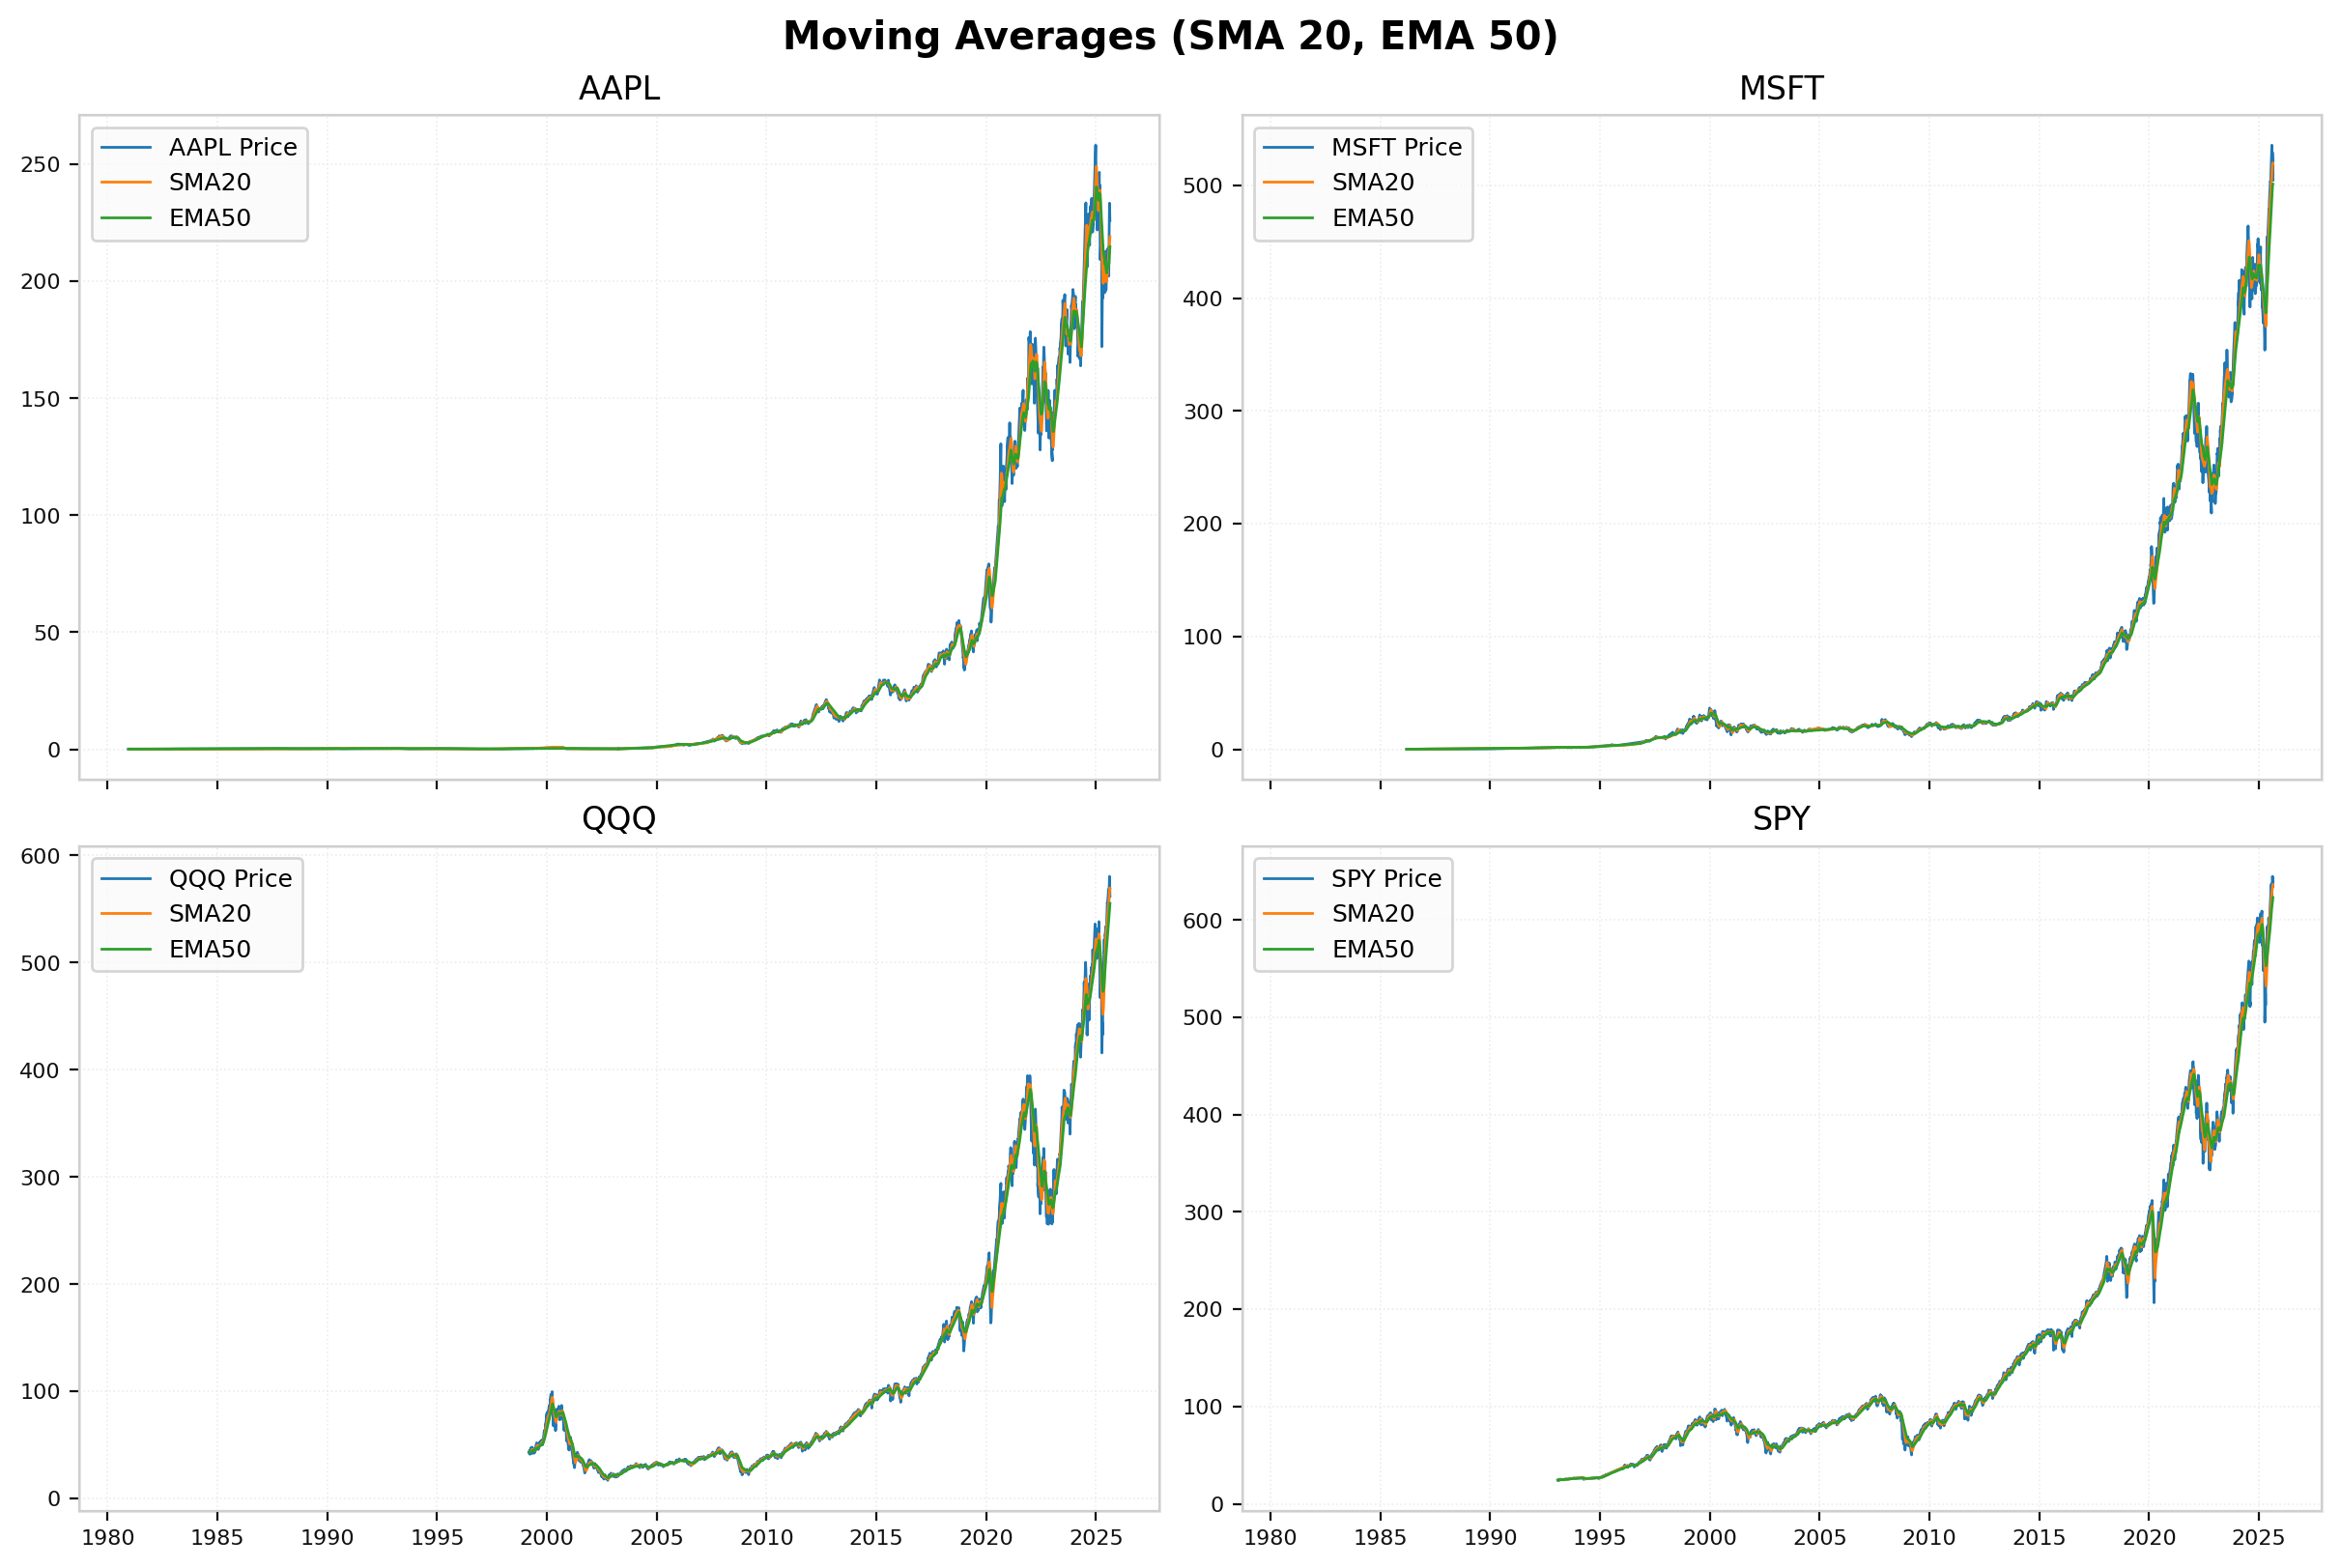

In [139]:
# --- Moving averages grid (replace your old plt.subplots cell) ---
fig, axs = create_figure(2, 2, sharex=True)
axs_flat = list(axs.flat)  # easy indexed iteration

for i, tk in enumerate(TICKERS_SUBSET):
    ax = axs_flat[i]

    # defensive: skip tickers not in the prices DataFrame
    if tk not in prices:
        ax.text(0.5, 0.5, "No data", ha="center", va="center", transform=ax.transAxes)
        ax.set_title(tk)
        ax.set_xlabel("")
        ax.set_ylabel("")
        continue

    # series and indicators
    s = prices[tk].dropna()
    if s.empty:
        ax.text(0.5, 0.5, "No price data", ha="center", va="center", transform=ax.transAxes)
        ax.set_title(tk)
        continue

    sma = s.rolling(MA_WINDOWS[0]).mean()
    ema = s.ewm(span=MA_WINDOWS[1], adjust=False).mean()

    # plot using Axes methods (consistent styling & avoids creating extra axes)
    ax.plot(s.index, s.values, label=f"{tk} Price", linewidth=1)
    ax.plot(sma.index, sma.values, label=f"SMA{MA_WINDOWS[0]}", linewidth=1)
    ax.plot(ema.index, ema.values, label=f"EMA{MA_WINDOWS[1]}", linewidth=1)

    ax.set_title(tk)
    ax.legend(loc="upper left", fontsize=9)

# hide any unused axes (if TICKERS_SUBSET has <4 items)
n_used = len(TICKERS_SUBSET)
for ax in axs_flat[n_used:]:
    ax.set_visible(False)

# Apply the framed styling and subtle grid to all axes
apply_style_to_figure(fig, grid=True, tick_fontsize=8)

# final touches
plt.suptitle(f"Moving Averages (SMA {MA_WINDOWS[0]}, EMA {MA_WINDOWS[1]})")
plt.show()


## 2. Technical Indicators (RSI, Bollinger Bands, MACD)

Four indicator plots for one ticker (edit PLOT_TICKER).

C:\Users\sherv\AppData\Local\Temp\ipykernel_16464\2826713254.py:110: UserWarning: The figure layout has changed to tight
  fig.tight_layout(rect=[0, 0.03, 1, 0.95])


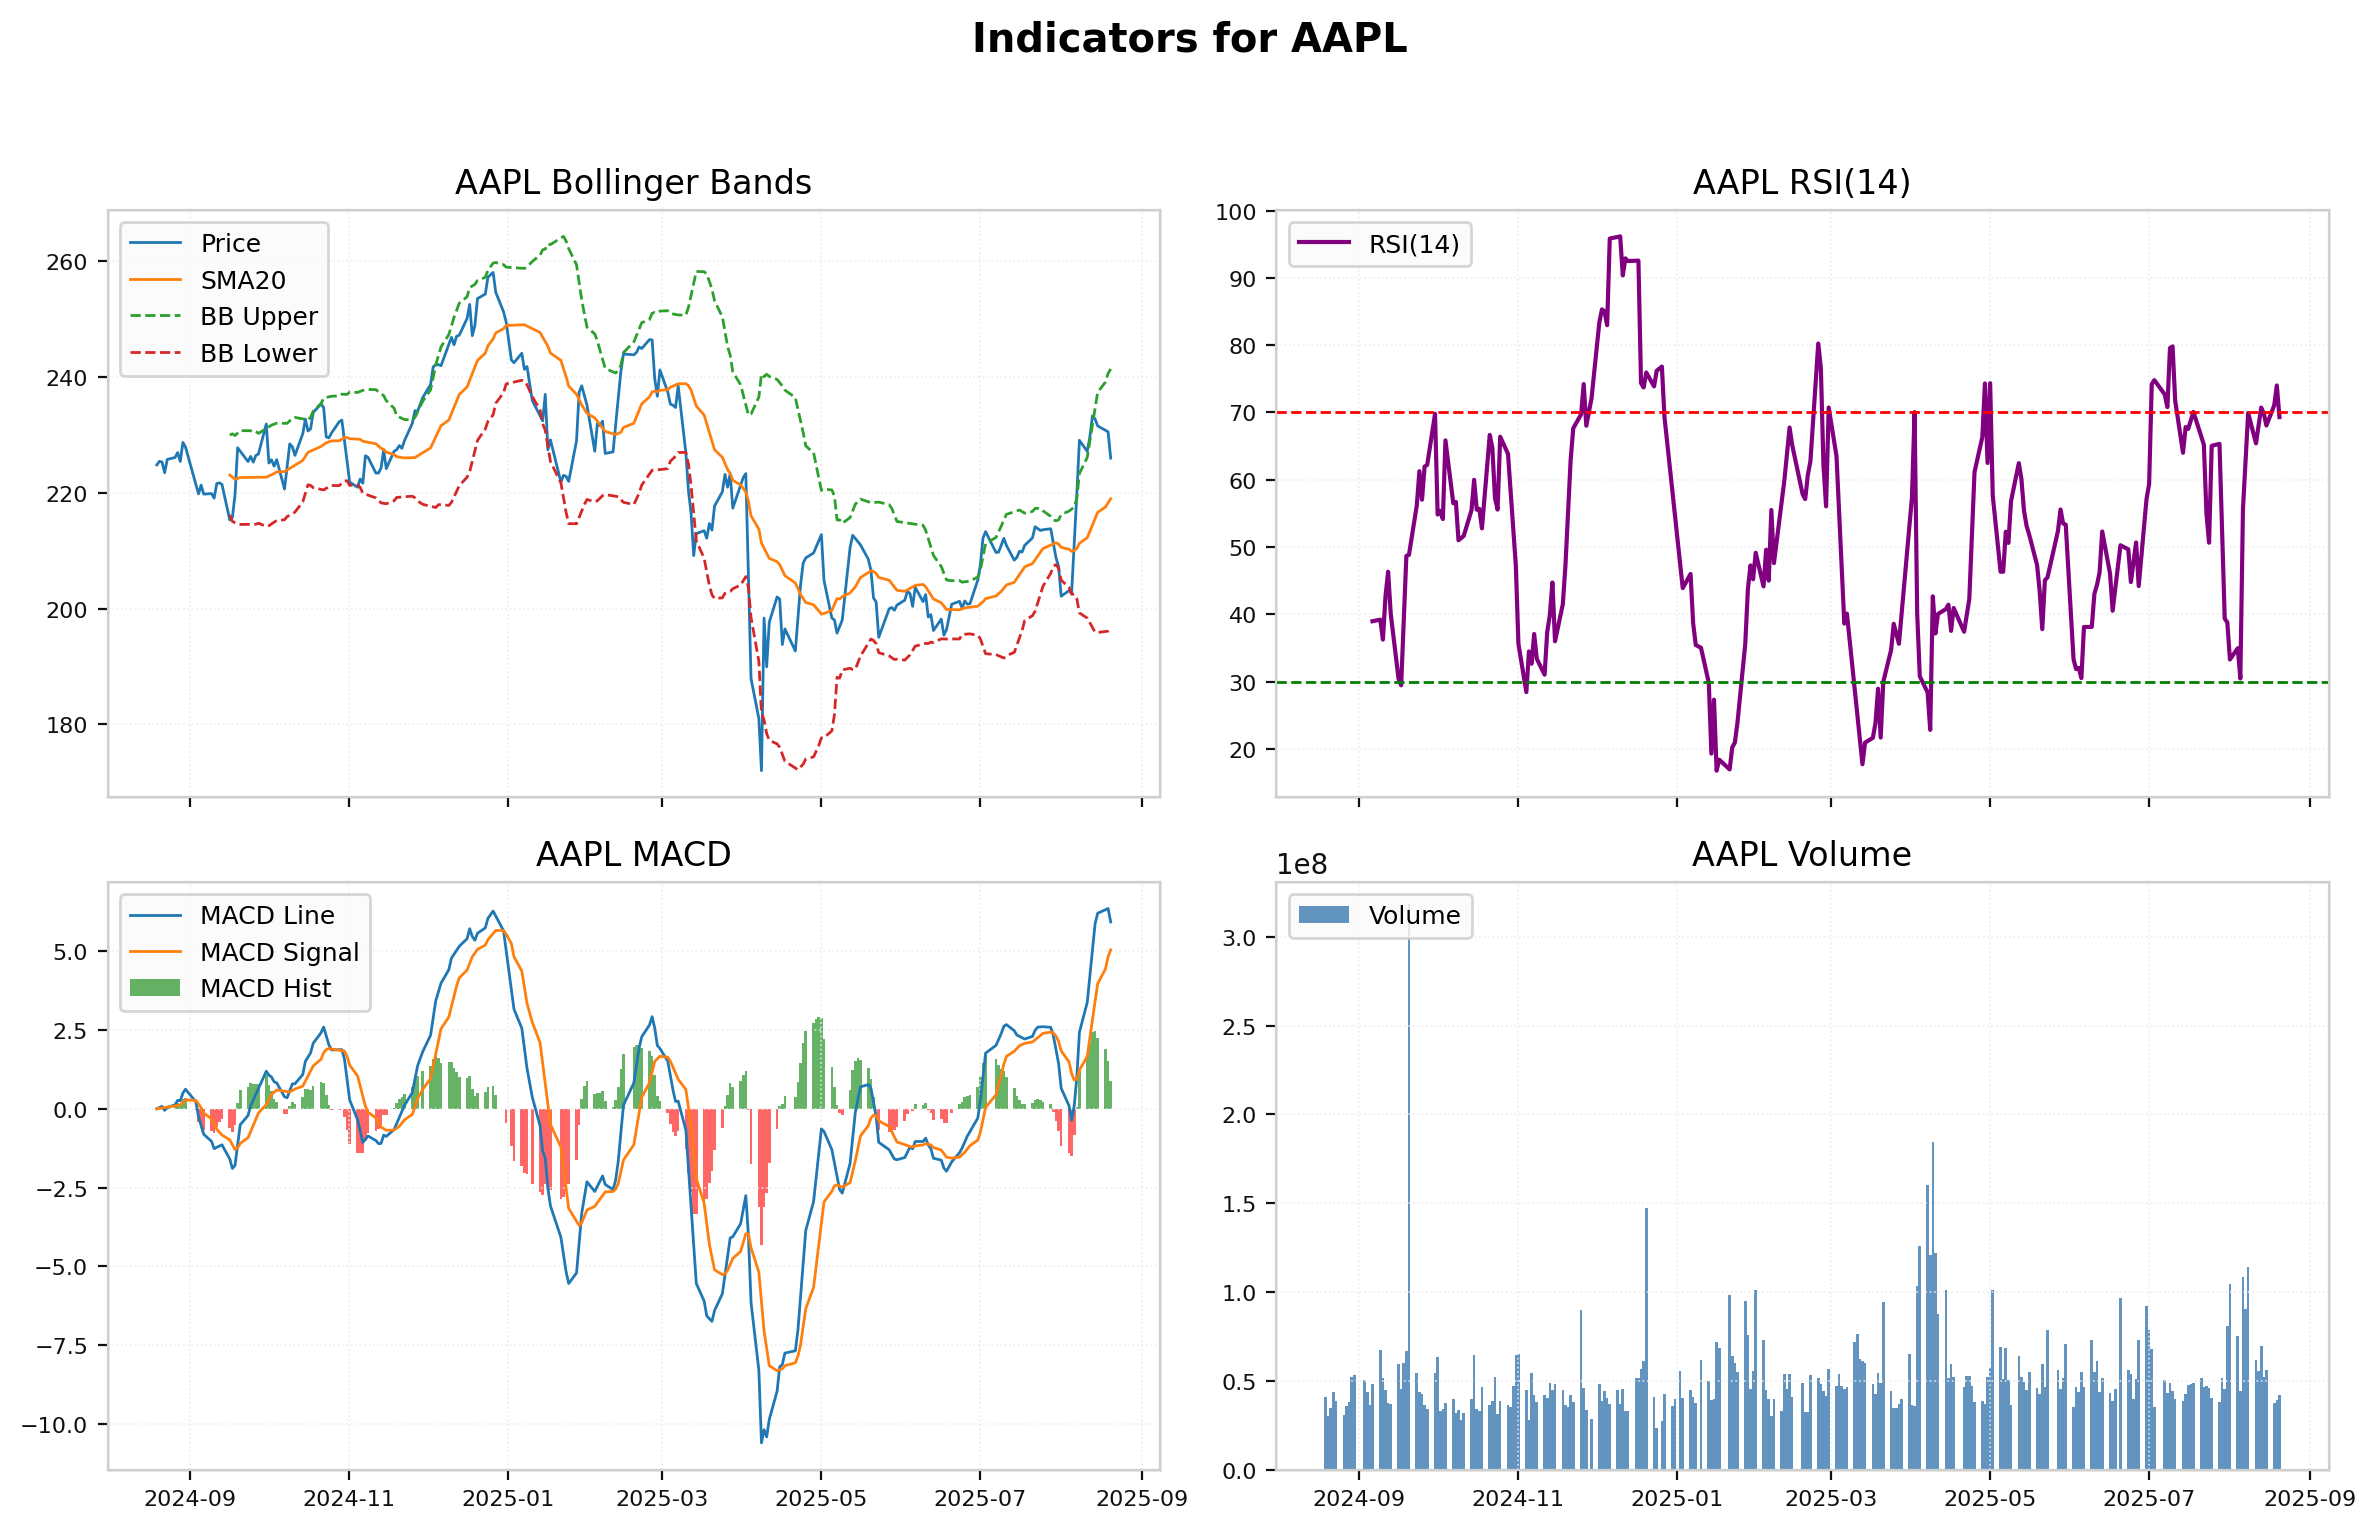

In [144]:
def plot_indicators_improved(
    ohlcv: pd.DataFrame,
    tk: str,
    bb_period: int = 20,
    rsi_period: int = 14,
    lookback: Optional[int] = 252,
    recent_vol_days: Optional[int] = 90,
    return_fig: bool = True,
    save_path: Optional[str] = None,
    figsize: Optional[Tuple[float, float]] = None,
):
    """
    Plot Bollinger Bands, RSI, MACD (colored histogram), and Volume for ticker `tk`.
    Uses create_figure(...) and apply_style_to_figure(...) from your global helpers.
    Returns (fig, axs) if return_fig=True, otherwise shows the figure and returns None.
    """
    # --- data prep ---
    df = ohlcv.loc[ohlcv["ticker"] == tk].copy()
    if df.empty:
        raise ValueError(f"No data for ticker {tk}")

    df = df.copy()
    df.index = pd.to_datetime(df["date"], errors="coerce")
    df = df.sort_index()
    # choose price column
    price_col = "adj_close" if "adj_close" in df.columns else "close"
    if price_col not in df.columns:
        raise ValueError("ohlcv must contain 'adj_close' or 'close'")

    s = df[price_col].dropna()
    if s.empty:
        raise ValueError("No non-null price data for ticker")

    # apply lookback
    if isinstance(lookback, int) and lookback > 0:
        s = s.tail(lookback)
        df = df.loc[s.index]

    # --- indicators ---
    sma = s.rolling(window=bb_period, min_periods=bb_period).mean()
    std = s.rolling(window=bb_period, min_periods=bb_period).std()
    upper = sma + 2 * std
    lower = sma - 2 * std

    rsi = RSI(s, period=rsi_period)
    macd_line, macd_signal, macd_hist = MACD(s)

    # volume (aligned to price index)
    vol_series = df["volume"].reindex(s.index) if "volume" in df.columns else pd.Series(dtype=float, index=s.index)

    # --- figure & axes (use your global helper so sizing is consistent) ---
    fig, axs = create_figure(2, 2, sharex=True)
    # axs is a 2D numpy array shaped (2,2)
    ax00, ax01, ax10, ax11 = axs[0,0], axs[0,1], axs[1,0], axs[1,1]

    # [0,0] Bollinger Bands
    ax = ax00
    ax.plot(s.index, s, label="Price", linewidth=1)
    ax.plot(sma.index, sma, label=f"SMA{bb_period}", linewidth=1)
    ax.plot(upper.index, upper, linestyle="--", linewidth=1, label="BB Upper")
    ax.plot(lower.index, lower, linestyle="--", linewidth=1, label="BB Lower")
    ax.set_title(f"{tk} Bollinger Bands")
    ax.legend(loc="upper left", fontsize=9)

    # [0,1] RSI
    ax = ax01
    ax.plot(rsi.index, rsi, color="purple", label=f"RSI({rsi_period})", linewidth=1.5)
    ax.axhline(70, color="red", linestyle="--", linewidth=1)
    ax.axhline(30, color="green", linestyle="--", linewidth=1)
    ax.set_title(f"{tk} RSI({rsi_period})")
    ax.legend(loc="upper left", fontsize=9)

    # [1,0] MACD
    ax = ax10
    ax.plot(macd_line.index, macd_line, label="MACD Line", linewidth=1)
    ax.plot(macd_signal.index, macd_signal, label="MACD Signal", linewidth=1)
    # color histogram by sign — align index properly and convert to numpy for colors
    macd_hist_filled = macd_hist.fillna(0)
    hist_vals = macd_hist_filled.values
    colors = np.where(hist_vals >= 0, "green", "red")
    ax.bar(macd_hist_filled.index, hist_vals, width=1, color=colors, alpha=0.6, label="MACD Hist")
    ax.set_title(f"{tk} MACD")
    ax.legend(loc="upper left", fontsize=9)

    # [1,1] Volume
    ax = ax11
    vol_vals = vol_series.dropna()
    if vol_vals.size > 0:
        # compute a robust ymax using percentile on recent window to avoid a single spike dominating
        recent = vol_vals.tail(recent_vol_days) if (recent_vol_days and recent_vol_days > 0) else vol_vals
        try:
            ymax = float(np.nanpercentile(vol_vals, 99.99))
        except Exception:
            ymax = float(recent.max())
        if not np.isfinite(ymax) or ymax <= 0:
            ymax = float(vol_vals.max() if vol_vals.size > 0 else 1.0)
    else:
        ymax = 1.0

    ax.bar(vol_series.index, vol_series.values, width=1, color="steelblue", alpha=0.85, label="Volume")
    ax.set_ylim(0, ymax * 1.05)
    ax.set_title(f"{tk} Volume")
    ax.legend(loc="upper left", fontsize=9)

    # --- apply framed styling to all axes and finalize ---
    apply_style_to_figure(fig, grid=True, tick_fontsize=8)

    plt.suptitle(f"Indicators for {tk}")
    # constrained layout is handled by create_figure; for safety:
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])

    if save_path:
        fig.savefig(save_path, dpi=150, bbox_inches="tight")

    if return_fig:
        return fig, axs
    else:
        plt.show()
        return None

fig, axs = plot_indicators_improved(ohlcv, "AAPL", lookback=252)
# to save:
# plot_indicators_improved(ohlcv, "AAPL", lookback=252, save_path="analysis/data/figures/aapl_indicators.png")

# In Streamlit
# fig, axs = plot_indicators_improved(ohlcv, "AAPL", lookback=180)
# st.pyplot(fig)

C:\Users\sherv\AppData\Local\Temp\ipykernel_16464\39023516.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


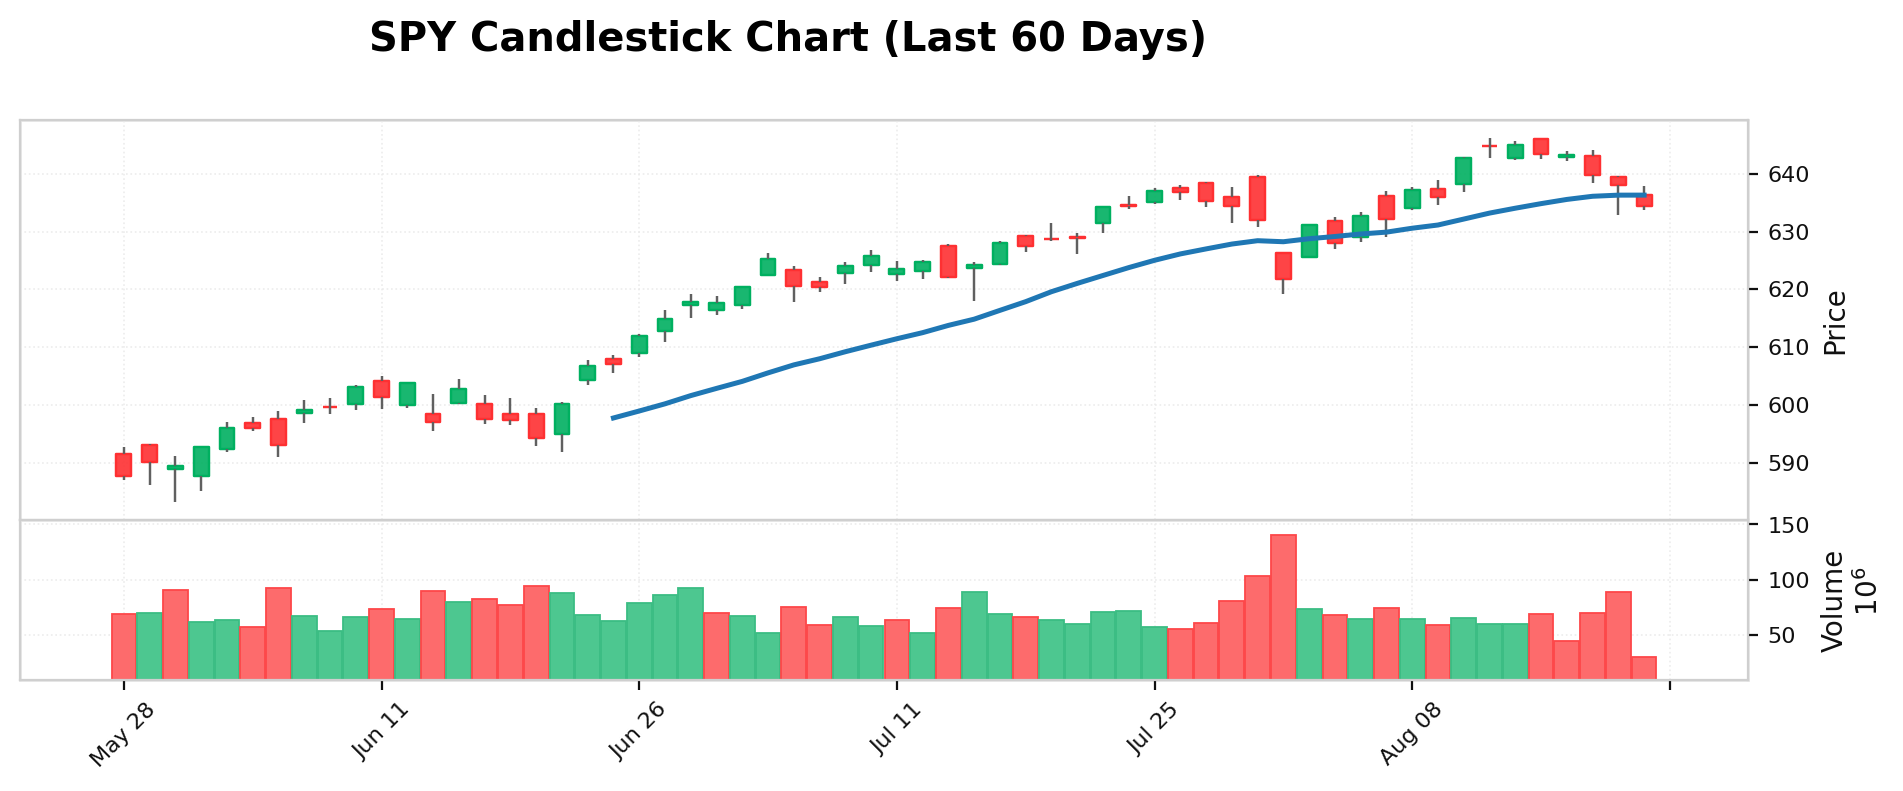

In [151]:
# --- derive the desired figsize from your global settings (fall back to 12x4) ---
width = globals().get("_DEFAULT_PLOT_WIDTH",
                      globals().get("PLOT_BASE_WIDTH", 12.0))
row_h = globals().get("_DEFAULT_ROW_HEIGHT",
                      globals().get("PLOT_BASE_ROW_HEIGHT", 4.0))

# For candlestick + volume one row is fine; if you prefer a taller plot use 1.25*row_h
figsize = (float(width), float(row_h))   # e.g. (12, 4)

# prepare the data (same as you had)
candle_df = (
    ohlcv[ohlcv["ticker"] == tk][["date","open","high","low","close","volume"]]
    .copy().set_index("date").sort_index().tail(60)
)
candle_df.index = pd.to_datetime(candle_df.index)

# ask mplfinance to use that figsize and return the figure so we can style it
fig, axes = mpf.plot(
    candle_df.rename(columns={"open":"Open","high":"High","low":"Low","close":"Close","volume":"Volume"}),
    type="candle",
    style="yahoo",
    mav=(20,),
    volume=True,
    title=f"{tk} Candlestick Chart (Last 60 Days)",
    ylabel="Price",
    ylabel_lower="Volume",
    show_nontrading=False,
    returnfig=True,
    figsize=figsize
)

# apply your framed style and final layout (safe tight_layout fallback)
apply_style_to_figure(fig, grid=True, tick_fontsize=8)

try:
    fig.tight_layout()
except RuntimeError:
    # constrained_layout/colorbar conflicts can happen in other contexts — ignore here
    pass

# rotate bottom x labels a bit for readability (volume axis is usually last)
axes_list = axes if isinstance(axes, (list, tuple)) else [axes]
bottom_ax = axes_list[-1]
for lbl in bottom_ax.get_xticklabels():
    lbl.set_rotation(30)
    lbl.set_ha("right")

plt.show()

## 3. Sharpe & Sortino Ratios

Compute risk-adjusted return ratios for subset.

In [142]:
returns = prices.pct_change().dropna()
rf = 0

def sharpe(series):
    mu = series.mean() * 252
    sigma = series.std() * np.sqrt(252)
    return (mu - rf) / sigma if sigma > 0 else np.nan

def sortino(series):
    neg_std = series[series < 0].std() * np.sqrt(252)
    mu = series.mean() * 252
    return (mu - rf) / neg_std if neg_std > 0 else np.nan

ratio_table = pd.DataFrame({
    "Sharpe": [sharpe(returns[tk]) for tk in TICKERS_SUBSET],
    "Sortino": [sortino(returns[tk]) for tk in TICKERS_SUBSET]
}, index=TICKERS_SUBSET)
display(ratio_table)


C:\Users\sherv\AppData\Local\Temp\ipykernel_16464\1850853378.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change().dropna()


,Sharpe,Sortino
AAPL,0.845879,1.159521
MSFT,1.019384,1.409449
QQQ,0.956148,1.220311
SPY,0.900200,1.099975


## 4. Correlations

Correlation heatmap (returns across your universe)
Rolling correlation (AAPL vs QQQ, 60d)

C:\Users\sherv\AppData\Local\Temp\ipykernel_16464\2658242798.py:5: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  rets = prices.pct_change().dropna(how="all")


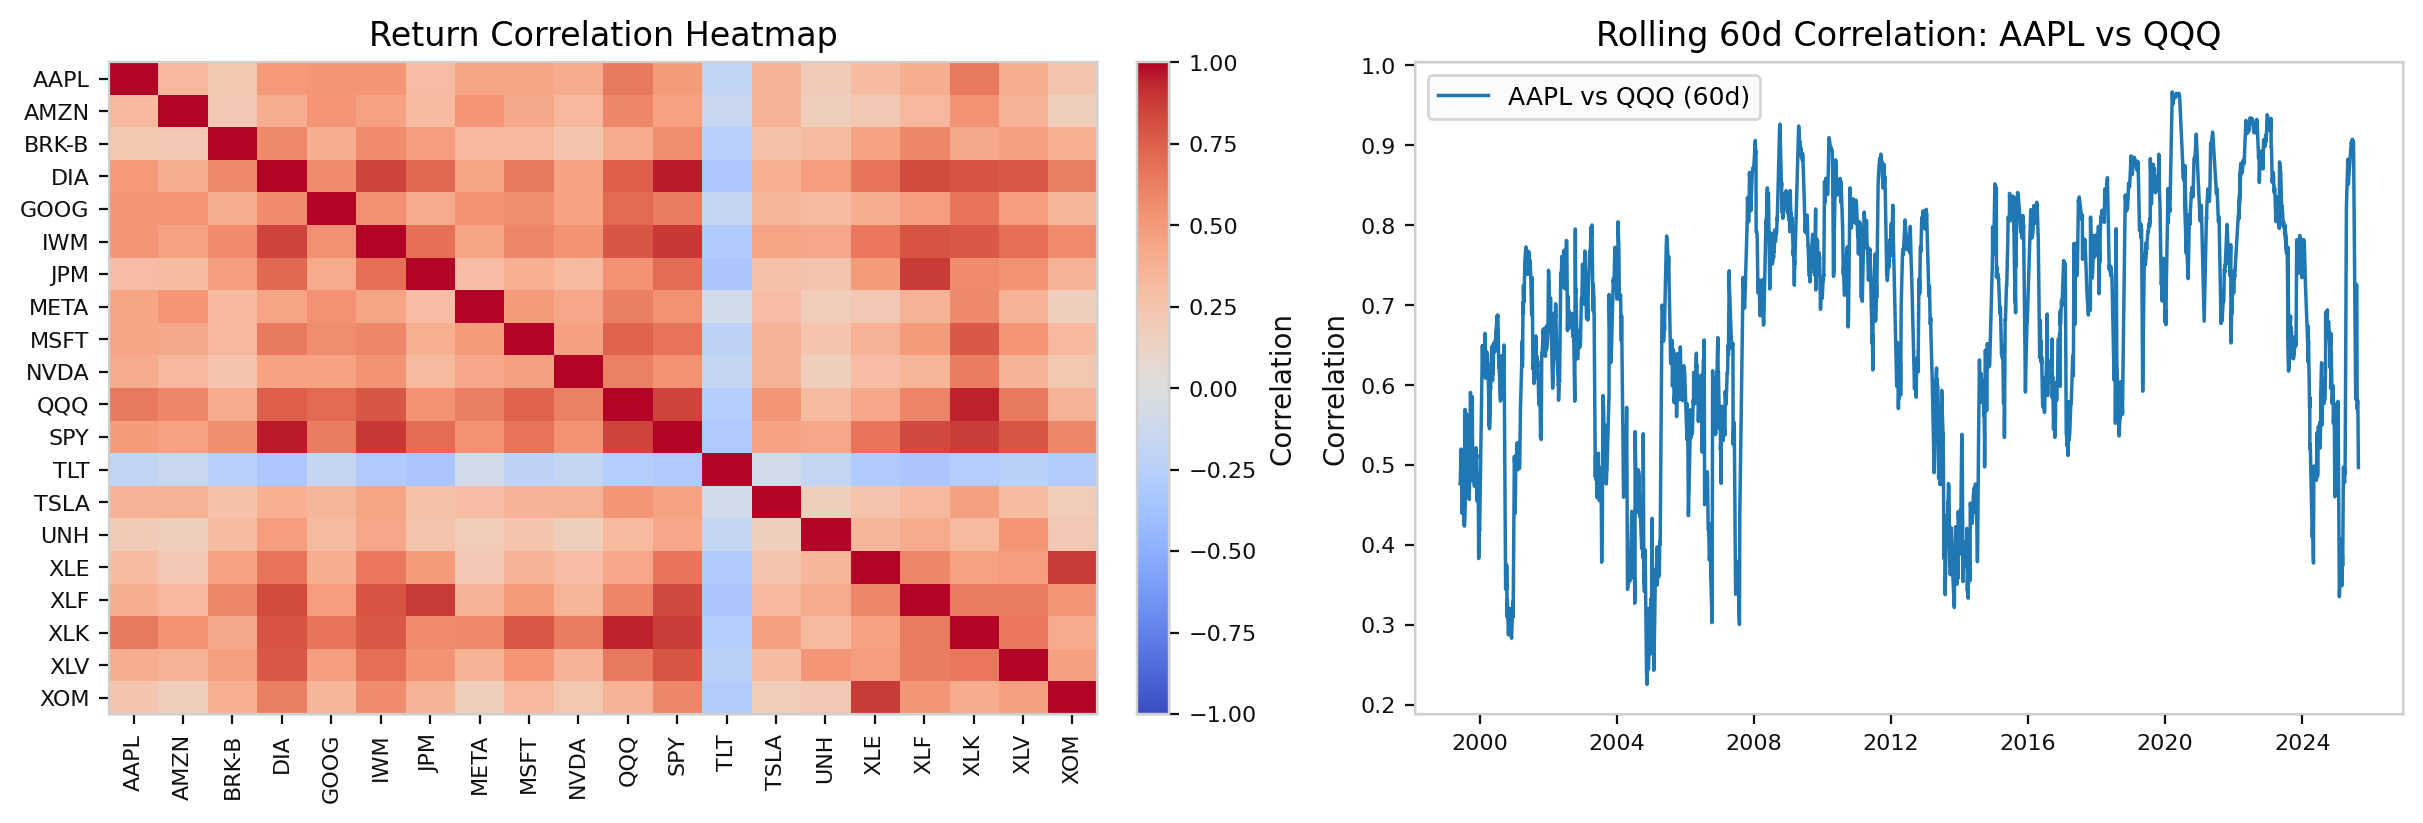

In [150]:
# Combined: heatmap (left) + 60d rolling correlation for a pair (right)
import numpy as np

# Prepare returns and corr matrix
rets = prices.pct_change().dropna(how="all")
corr = rets.corr().fillna(0)

pair = ("AAPL", "QQQ")  # change as desired

# Create 1x2 figure (uses global create_figure sizing)
fig, axs = create_figure(1, 2, sharex=False)
ax_heat, ax_roll = axs[0, 0], axs[0, 1]

# ---- Left: heatmap ----
# Use imshow; aspect='auto' keeps cells rectangular when many tickers
im = ax_heat.imshow(corr.values, cmap="coolwarm", vmin=-1, vmax=1, aspect="auto", interpolation="nearest", origin="upper")

n = len(corr.columns)
ticks = np.arange(n)

# Downsample tick labels if many tickers to avoid overlap
max_ticks = 30
if n > max_ticks:
    step = max(1, n // max_ticks)
    xt_idxs = ticks[::step]
    yt_idxs = ticks[::step]
    ax_heat.set_xticks(xt_idxs)
    ax_heat.set_xticklabels(corr.columns[::step], rotation=90, fontsize=8)
    ax_heat.set_yticks(yt_idxs)
    ax_heat.set_yticklabels(corr.index[::step], fontsize=8)
else:
    ax_heat.set_xticks(ticks)
    ax_heat.set_xticklabels(corr.columns, rotation=90, fontsize=9)
    ax_heat.set_yticks(ticks)
    ax_heat.set_yticklabels(corr.index, fontsize=9)

ax_heat.set_title("Return Correlation Heatmap")

# colorbar anchored to the heatmap axis (keeps layout stable)
cbar = fig.colorbar(im, ax=ax_heat, fraction=0.046, pad=0.04)
cbar.set_label("Correlation")

# Optionally annotate if small matrix (uncomment to enable)
# if n <= 12:
#     for i in range(n):
#         for j in range(n):
#             ax_heat.text(j, i, f"{corr.iat[i,j]:.2f}", ha="center", va="center", fontsize=7)

# ---- Right: rolling 60d correlation for a pair ----
if all(tk in rets.columns for tk in pair):
    rollcorr = rets[pair[0]].rolling(60).corr(rets[pair[1]])
    ax_roll.plot(rollcorr.index, rollcorr.values, linewidth=1.25, label=f"{pair[0]} vs {pair[1]} (60d)")
    ax_roll.set_title(f"Rolling 60d Correlation: {pair[0]} vs {pair[1]}")
    ax_roll.set_ylabel("Correlation")
    ax_roll.legend(loc="upper left", fontsize=9)
    ax_roll.axhline(0, color="gray", lw=0.8, alpha=0.7)  # zero line helps interpretation

    # keep autoscaling but add a small visual padding if desired
    valid = rollcorr.dropna()
    if not valid.empty:
        vmin, vmax = float(valid.min()), float(valid.max())
        if vmin == vmax:
            pad = 0.05
        else:
            pad = max((vmax - vmin) * 0.05, 0.02)
        ax_roll.set_ylim(vmin - pad, vmax + pad)
else:
    ax_roll.text(0.5, 0.5, "Pair not available in returns", ha="center", va="center", transform=ax_roll.transAxes)
    ax_roll.set_title(f"Rolling 60d Correlation: {pair[0]} vs {pair[1]}")

# Apply framed styling to both axes (use your helper)
apply_style_to_figure(fig, grid=False, tick_fontsize=8)

plt.show()


## 5. Drawdown Analysis

Drawdown plots for subset in 2x2 grid.

C:\Users\sherv\AppData\Local\Temp\ipykernel_16464\161829552.py:37: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


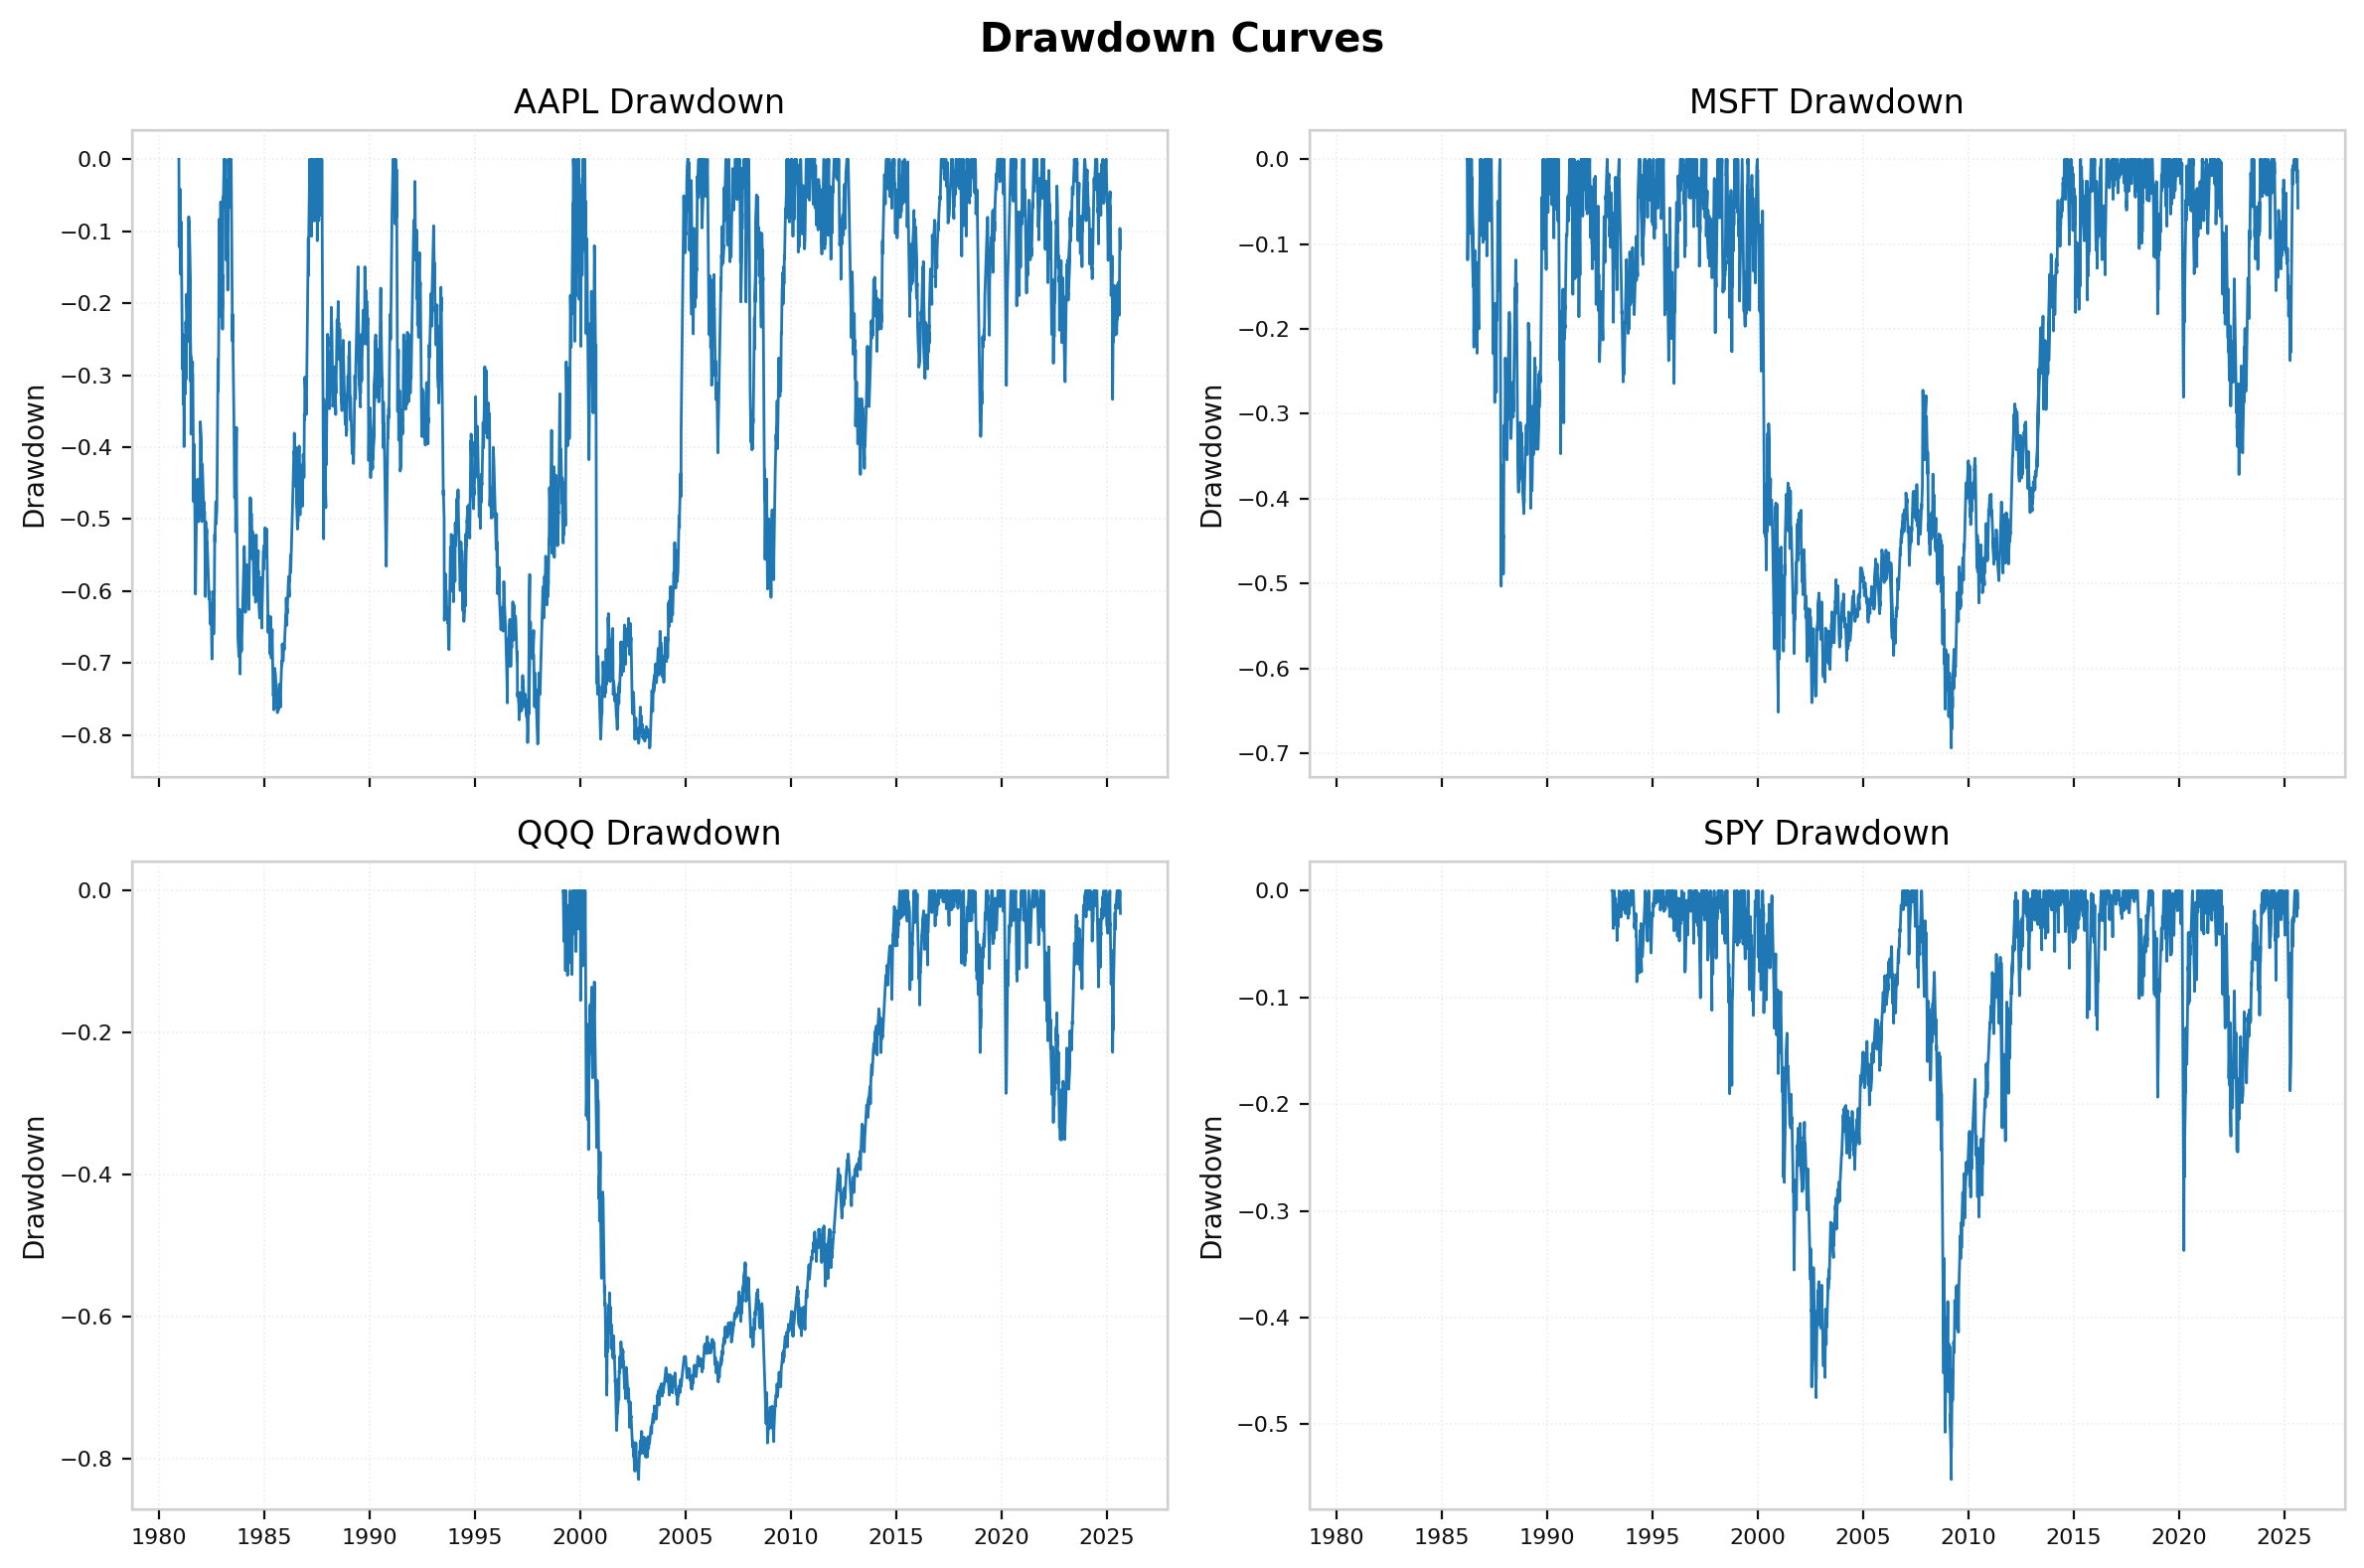

In [147]:
def drawdown(series: pd.Series) -> pd.Series:
    roll_max = series.cummax()
    dd = series / roll_max - 1
    return dd

# Use your create_figure helper so sizing/constrained-layout is consistent
fig, axs = create_figure(2, 2, sharex=True)
axs_flat = list(axs.flat)

for i, tk in enumerate(TICKERS_SUBSET):
    ax = axs_flat[i]

    # defensive: handle missing or empty series without raising
    if tk not in prices or prices[tk].dropna().empty:
        ax.text(0.5, 0.5, "No data", ha="center", va="center", transform=ax.transAxes)
        ax.set_title(tk)
        ax.set_ylabel("Drawdown")
        continue

    s = prices[tk].dropna()
    dd = drawdown(s)

    # use Axes.plot directly (keeps control and avoids pandas creating new axes)
    ax.plot(dd.index, dd.values, linewidth=1)
    ax.set_title(f"{tk} Drawdown")
    ax.set_ylabel("Drawdown")

# hide any unused axes (in case TICKERS_SUBSET has < 4 tickers)
n_used = len(TICKERS_SUBSET)
for ax in axs_flat[n_used:]:
    ax.set_visible(False)

# apply your framed styling to match the rest of the notebook
apply_style_to_figure(fig, grid=True, tick_fontsize=8)

plt.suptitle("Drawdown Curves")
fig.tight_layout()
plt.show()

## 6. Beta & Alpha (CAPM) & Portfolio Simulation (Equal vs Vol-Weighted)

- Compute beta and alpha vs SPY and show scatter fit for AAPL.
- Compare cumulative returns for equal-weight and volatility-weighted portfolios.

,Beta,Alpha
Ticker,,
AAPL,1.185060,0.000241
MSFT,1.175056,0.000349
QQQ,1.143887,0.000097


C:\Users\sherv\AppData\Local\Temp\ipykernel_16464\2938483944.py:81: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


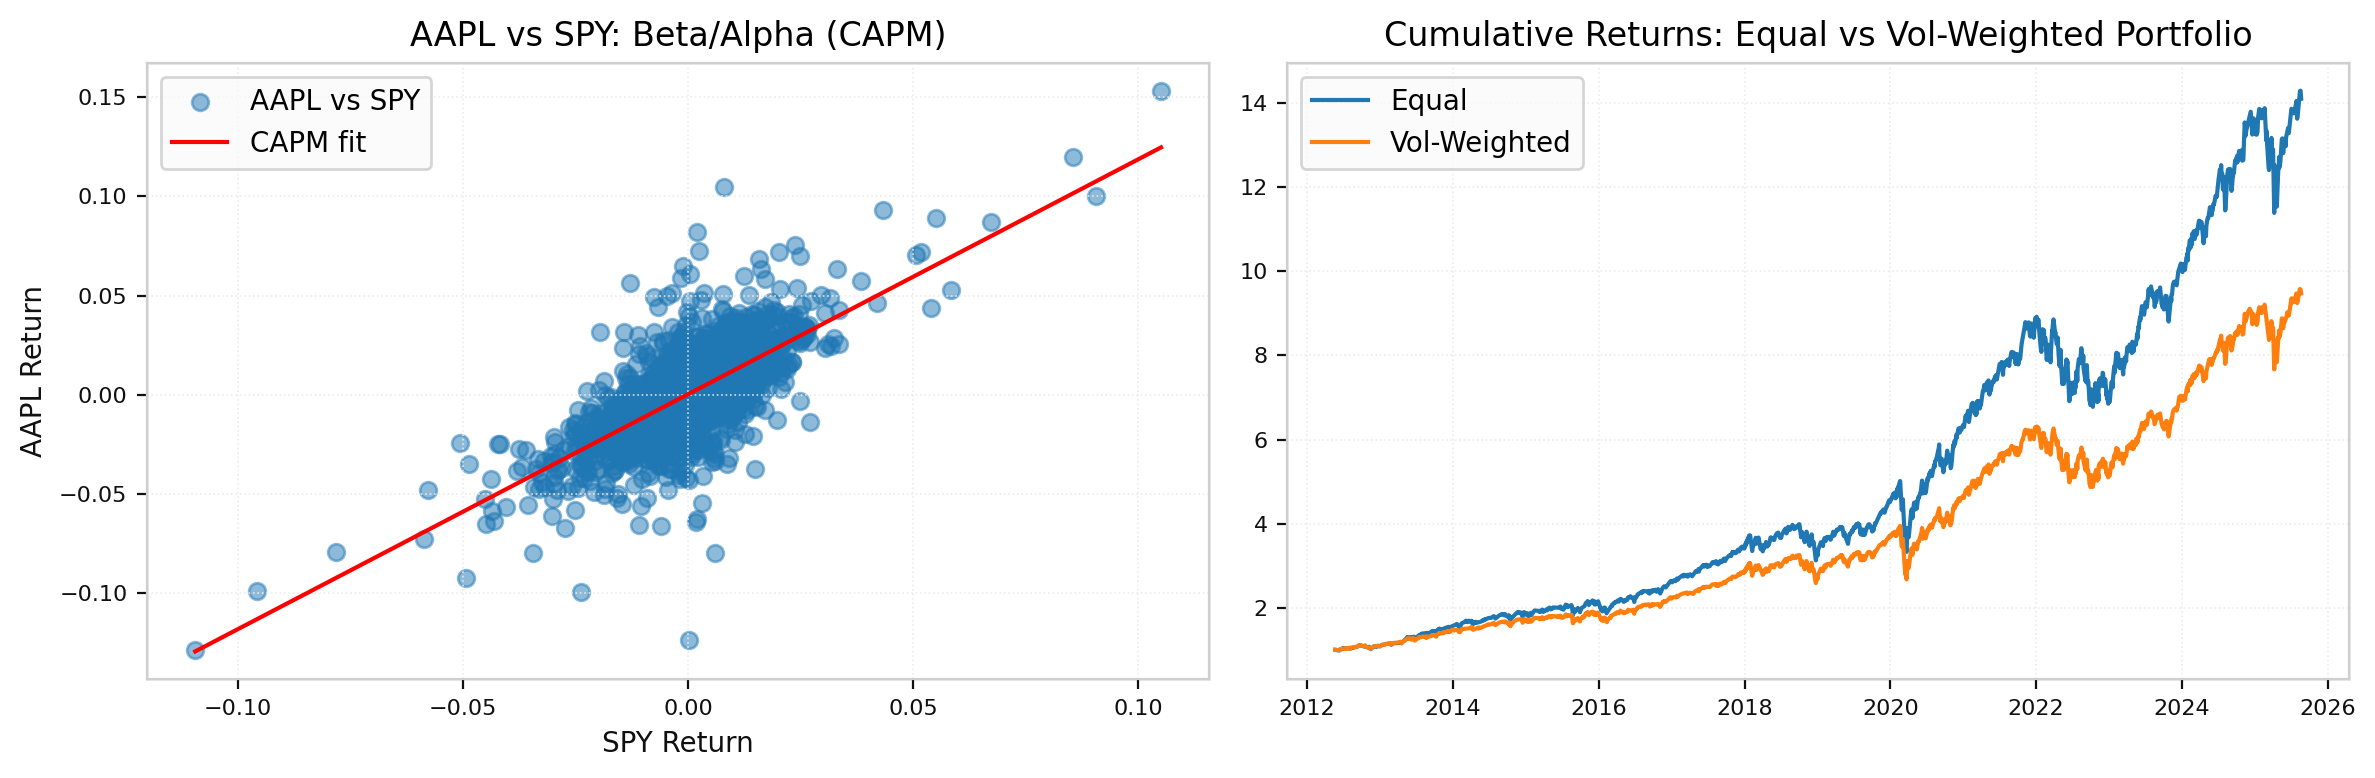

In [148]:
# --- 1) CAPM per asset (skip SPY) ---
subset = TICKERS_SUBSET
results = []
for tk in subset:
    if tk == "SPY":
        continue
    y = returns[tk].dropna()
    x = returns["SPY"].reindex_like(y).dropna()
    # align to common index
    common = y.index.intersection(x.index)
    y = y.loc[common]
    x = x.loc[common]
    if y.empty or x.empty:
        results.append({"Ticker": tk, "Beta": np.nan, "Alpha": np.nan})
        continue
    X = sm.add_constant(x)
    capm = sm.OLS(y, X, missing="drop").fit()
    results.append({"Ticker": tk, "Beta": float(capm.params["SPY"]), "Alpha": float(capm.params["const"])})

capm_df = pd.DataFrame(results).set_index("Ticker")
display(capm_df)

# --- 2) Create 1x2 figure: left = scatter (AAPL vs SPY), right = cumulative ports ---
fig, axs = create_figure(1, 2, sharex=False)
ax_scatter = axs[0, 0]
ax_cum = axs[0, 1]

# Left: scatter AAPL vs SPY + CAPM fit (if data & AAPL present)
if "AAPL" in returns.columns and "SPY" in returns.columns:
    y = returns["AAPL"].dropna()
    x = returns["SPY"].reindex_like(y).dropna()
    common = y.index.intersection(x.index)
    y = y.loc[common]
    x = x.loc[common]

    if not y.empty and not x.empty and "AAPL" in capm_df.index:
        ax_scatter.scatter(x, y, alpha=0.5, label="AAPL vs SPY")
        beta, alpha = capm_df.loc["AAPL", ["Beta", "Alpha"]]
        # regression line (drawn across the x-range)
        x_vals = np.linspace(x.min(), x.max(), 200)
        ax_scatter.plot(x_vals, alpha + beta * x_vals, color="red", label="CAPM fit")
        ax_scatter.set_xlabel("SPY Return")
        ax_scatter.set_ylabel("AAPL Return")
        ax_scatter.set_title("AAPL vs SPY: Beta/Alpha (CAPM)")
        ax_scatter.legend()
    else:
        ax_scatter.text(0.5, 0.5, "Insufficient data for AAPL vs SPY", ha="center", va="center", transform=ax_scatter.transAxes)
        ax_scatter.set_title("AAPL vs SPY: Beta/Alpha (CAPM)")
else:
    ax_scatter.text(0.5, 0.5, "AAPL or SPY missing in returns", ha="center", va="center", transform=ax_scatter.transAxes)
    ax_scatter.set_title("AAPL vs SPY: Beta/Alpha (CAPM)")

# Right: cumulative returns Equal vs Vol-Weighted (60d vol)
vol = returns.rolling(60).std().iloc[-1]
n_assets = returns.shape[1]
# equal weights as Series (indexed)
w_eq = pd.Series(1.0 / n_assets, index=returns.columns)

# robust inverse-vol weights (fallback to equal if something goes wrong)
inv_vol = 1.0 / vol.replace(0, np.nan)
if not np.isfinite(inv_vol).any() or inv_vol.isna().all():
    w_vw = w_eq.copy()
else:
    # fill any NaNs with columnwise mean inverse-vol (simple fallback)
    inv_vol = inv_vol.fillna(inv_vol.mean())
    w_vw = inv_vol / inv_vol.sum()
    w_vw = w_vw.reindex(returns.columns).fillna(0)

# portfolio returns and cumulative
port_eq = (returns * w_eq).sum(axis=1)
port_vw = (returns * w_vw).sum(axis=1)
cum = pd.DataFrame({"Equal": port_eq, "Vol-Weighted": port_vw}).add(1).cumprod()

ax_cum.plot(cum.index, cum["Equal"], label="Equal")
ax_cum.plot(cum.index, cum["Vol-Weighted"], label="Vol-Weighted")
ax_cum.set_title("Cumulative Returns: Equal vs Vol-Weighted Portfolio")
ax_cum.legend()

# Apply your framed styling and finish
apply_style_to_figure(fig, grid=True, tick_fontsize=8)
fig.tight_layout()
plt.show()

# Finance Metrics & Plots Cheatsheet

## 1. Moving Averages

**Simple Moving Average (SMA):**
- The arithmetic mean of closing prices over the last _N_ periods.
- **Formula:**  
  `SMA_N = (P_t + P_{t-1} + ... + P_{t-N+1}) / N`
- **Use:** Smooths short-term price fluctuations, identifies trends.

**Exponential Moving Average (EMA):**
- Weighted average that gives more importance to recent prices.
- **Formula (recursively):**  
  `EMA_t = α * P_t + (1-α) * EMA_{t-1}`  
  where `α = 2 / (N+1)`
- **Use:** Responds faster to price changes than SMA.

---

## 2. Bollinger Bands

- Volatility envelope drawn above and below SMA (usually 20 days).
- **Upper Band:** SMA + 2 × rolling standard deviation  
- **Lower Band:** SMA - 2 × rolling standard deviation
- **Interpretation:**  
  Price touching upper/lower bands may indicate overbought/oversold conditions.

---

## 3. Relative Strength Index (RSI)

- **Momentum oscillator**: measures speed and change of price movements.
- **Scale:** 0–100; overbought >70, oversold <30.
- **Formula:**  
  `RSI = 100 - (100 / (1 + RS))`  
  Where `RS = average gain / average loss`
- **Use:** Detects potential reversal points.

---

## 4. MACD (Moving Average Convergence Divergence)

- **Trend-following momentum indicator**
- **MACD Line:** 12-day EMA minus 26-day EMA
- **Signal Line:** 9-day EMA of the MACD Line
- **Histogram:** MACD Line minus Signal Line
- **Use:** Signal crossovers (buy/sell), divergence from price.

---

## 5. Volume

- **Total shares/contracts traded in a given time period.**
- **Use:** High volume often confirms price moves or signals possible reversals.

---

## 6. Sharpe Ratio

- **Risk-adjusted return:**  
  `Sharpe = (E[R] - R_f) / σ`  
  Where `E[R]` is expected return, `R_f` is risk-free rate, `σ` is volatility.
- **Use:** Higher Sharpe means better risk-adjusted performance.

---

## 7. Sortino Ratio

- Like Sharpe, but penalizes only downside volatility (bad risk).
- `Sortino = (E[R] - R_f) / σ_D`  
  Where `σ_D` is std. dev. of negative returns only.

---

## 8. Drawdown

- **Drawdown:** Percentage drop from previous peak.
- `Drawdown_t = (P_t - Peak_t) / Peak_t`
- **Use:** Measures risk of large losses; max drawdown is key portfolio risk metric.

---

## 9. Beta & Alpha (CAPM)

- **Beta:** Measures sensitivity to market (e.g., SPY).  
  `Beta = Cov(R_stock, R_mkt) / Var(R_mkt)`
- **Alpha:** Excess return not explained by beta (i.e., skill).  
  `Alpha = E[R_stock] - R_f - Beta * (E[R_mkt] - R_f)`
- **Use:**  
  - Beta >1: more volatile than market  
  - Alpha >0: outperformance

---

## 10. Portfolio Simulation

- **Equal-weight portfolio:** Each asset weighted equally.
- **Volatility-weighted portfolio:** Lower-vol assets get higher weight.
- **Cumulative returns:**  
  `Cumulative Return_t = Product_{i=1}^t (1 + r_i)`
- **Use:** Compare portfolio strategies over time.

---

## 11. Candlestick Plot

- **Shows:** Open, high, low, close for each period as a "candle".
  - Green/up candle: close > open (body is hollow or green)
  - Red/down candle: close < open (body is filled or red)
- **Use:** Quickly visualizes price trends, gaps, and volatility.

---

## 12. RSI, MACD, Stochastic, Volume—How to Interpret

- **RSI:** High (>70) means overbought, low (<30) means oversold.
- **MACD:** Cross above signal line = bullish, below = bearish.
- **Stochastic:** Similar to RSI, but often generates more frequent signals.
- **Volume:** Spikes confirm price moves, divergences may warn of reversals.

---

